# Оптимизация маркетинговых затрат в Яндекс.Афише

### Загрузим данные и подготовим их к анализу

Нас пригласили на стажировку в отдел маркетинговой аналитики Яндекс.Афиши.
Первое задание: помочь маркетологам снизить расходы — отказаться от невыгодных источников трафика и перераспределить бюджет.

Загрузим данные о визитах, заказах и рекламных расходах из CSV-файлов в переменные.

Изучим данные и выполним предобработку. 

**Описание данных**

В нашем распоряжении три датасета. 

Файл `visits_info_short.csv` хранит лог сервера с информацией о посещениях сайта,

`orders_info_short.csv` — информацию о заказах, 

а `costs_info_short.csv` — информацию о расходах на рекламу.


Структура `visits_info_short.csv`:
- `User Id` — уникальный идентификатор пользователя,
- `Region` — страна пользователя,
- `Device `— тип устройства пользователя,
- `Channel` — идентификатор источника перехода,
- `Session Start` — дата и время начала сессии,
- `Session End` — дата и время окончания сессии.

Структура `orders_info_short.csv`:
- `User Id` — уникальный идентификатор пользователя,
- `Event Dt` — дата и время покупки,
- `Revenue` — сумма заказа.

Структура `costs_info_short.csv`:
- `dt` — дата проведения рекламной кампании,
- `Channel` — идентификатор рекламного источника,
- `costs` — расходы на эту кампанию.

**Задача**

Разобраться в причинах убытка компании.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as st
import seaborn
from datetime import datetime, timedelta

In [3]:
try:
    visits = pd.read_csv('/datasets/visits_info_short.csv')
    orders = pd.read_csv('/datasets/orders_info_short.csv')
    costs = pd.read_csv('/datasets/costs_info_short.csv')
except:
    visitis = pd.read_csv('visits_info_short.csv')
    orders = pd.read_csv('orders_info_short.csv')
    costs = pd.read_csv('costs_info_short.csv')

In [4]:
print(visits.head())
print('')
print(orders.head())
print('')
print(costs.head())

        User Id         Region   Device  Channel        Session Start  \
0  981449118918  United States   iPhone  organic  2019-05-01 02:36:01   
1  278965908054  United States   iPhone  organic  2019-05-01 04:46:31   
2  590706206550  United States      Mac  organic  2019-05-01 14:09:25   
3  326433527971  United States  Android   TipTop  2019-05-01 00:29:59   
4  349773784594  United States      Mac  organic  2019-05-01 03:33:35   

           Session End  
0  2019-05-01 02:45:01  
1  2019-05-01 04:47:35  
2  2019-05-01 15:32:08  
3  2019-05-01 00:54:25  
4  2019-05-01 03:57:40  

        User Id             Event Dt  Revenue
0  188246423999  2019-05-01 23:09:52     4.99
1  174361394180  2019-05-01 12:24:04     4.99
2  529610067795  2019-05-01 11:34:04     4.99
3  319939546352  2019-05-01 15:34:40     4.99
4  366000285810  2019-05-01 13:59:51     4.99

           dt   Channel  costs
0  2019-05-01  FaceBoom  113.3
1  2019-05-02  FaceBoom   78.1
2  2019-05-03  FaceBoom   85.8
3  2019-0

In [5]:
print(visits.info())
print('')
print(orders.info())
print('')
print(costs.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB
None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB
None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #

**Переименуем столбцы**

In [6]:
visits.columns = visits.columns.str.lower()
orders.columns = orders.columns.str.lower()
costs.columns = costs.columns.str.lower()

In [7]:
visits.rename(columns={'user id': 'user_id', 'session start': 'session_start',
                       'session end': 'session_end'}, inplace=True)
orders.rename(columns={'user id': 'user_id', 'event dt': 'event_dt'}, inplace=True)

**Преобразуем данные о времени**

In [8]:
visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])
orders['event_dt'] = pd.to_datetime(orders['event_dt'])
costs['dt'] = pd.to_datetime(costs['dt']).dt.date

**Проверка на дубликаты**

In [9]:
print('Дубликаты в visits, orders, costs:',
    visits.duplicated().sum(),
    orders.duplicated().sum(),
    costs.duplicated().sum()
)

Дубликаты в visits, orders, costs: 0 0 0


**Просматриваем уникальные значения в столбцах данных**

In [10]:
print(visits['region'].unique())
print(visits['device'].unique())
print(visits['channel'].unique())

['United States' 'UK' 'France' 'Germany']
['iPhone' 'Mac' 'Android' 'PC']
['organic' 'TipTop' 'RocketSuperAds' 'YRabbit' 'FaceBoom' 'MediaTornado'
 'AdNonSense' 'LeapBob' 'WahooNetBanner' 'OppleCreativeMedia'
 'lambdaMediaAds']


**Вывод**

В данных нет пропусков, нет дубликатов. Изменили тип данных у столбов со временем, чтобы в дальнейшем с ними было удобно работать. Также привели названия столбцов к стилистически корректному виду. 

### Зададим функции для расчёта и анализа LTV, ROI, удержания и конверсии.

#### `get_profiles()`

**Создадим функцию `get_profiles()` для создания профилей пользователей**

In [11]:
def get_profiles(visits, orders, ad_costs, event_names=[]):

    profiles = (
        visits.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'}) # first timestamp — первая временная отметка
        .reset_index()
    )
    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')
    
    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique()) 

    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)


    return profiles


#### `get_retention()`

**Создадим функцию `get_retention()` для подсчёта Retention Rate (удержания)**

In [12]:
def get_retention(
    profiles,
    visits,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        visits[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

#### `get_conversion()`

**Создадим функцию `get_conversion()` для подсчёта конверсии**

In [13]:
def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

#### `get_ltv()`

**Создадим функцию `get_ltv()` для подсчёта LTV**

In [14]:
def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    ) 

#### `filter_data()`

**Создадим функцию `filter_data` для сглаживания фрейма**

In [15]:
def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df 

#### `plot_retention()`

**Создадим функцию `plot_retention` для визуализации удержания**

In [16]:
def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3, sharey=ax1)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax1)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show() 

#### `plot_conversion()`

**Создадим функцию `plot_conversion` для визуализации конверсии**

In [17]:
def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 

#### `plot_ltv_roi`

**Создадим функцию `plot_ltv_roi` для визуализации LTV и ROI**

In [18]:
def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 

### Исследовательский анализ данных

- Составим профили пользователей. Определим минимальную и максимальную даты привлечения пользователей.
- Выясним, из каких стран пользователи приходят в приложение и на какую страну приходится больше всего платящих пользователей. Построим таблицу, отражающую количество пользователей и долю платящих из каждой страны.
- Узнаем, какими устройствами пользуются клиенты и какие устройства предпочитают платящие пользователи. Построим таблицу, отражающую количество пользователей и долю платящих для каждого устройства.
- Изучим рекламные источники привлечения и определите каналы, из которых пришло больше всего платящих пользователей. Построим таблицу, отражающую количество пользователей и долю платящих для каждого канала привлечения.

#### Составим профили пользователей. Определим минимальную и максимальную даты привлечения пользователей.

In [19]:
profiles = get_profiles(visits, orders, costs)
print(profiles.head(5)) 

    user_id            first_ts     channel  device         region  \
0    599326 2019-05-07 20:58:57    FaceBoom     Mac  United States   
1   4919697 2019-07-09 12:46:07    FaceBoom  iPhone  United States   
2   6085896 2019-10-01 09:58:33     organic  iPhone         France   
3  22593348 2019-08-22 21:35:48  AdNonSense      PC        Germany   
4  31989216 2019-10-02 00:07:44     YRabbit  iPhone  United States   

           dt      month  payer  acquisition_cost  
0  2019-05-07 2019-05-01   True          1.088172  
1  2019-07-09 2019-07-01  False          1.107237  
2  2019-10-01 2019-10-01  False          0.000000  
3  2019-08-22 2019-08-01  False          0.988235  
4  2019-10-02 2019-10-01  False          0.230769  


In [20]:
print(profiles['dt'].min())
print(profiles['dt'].max())

2019-05-01
2019-10-27


**Вывод**

У нас представлны данные привлечённых пользователей с 1 мая по 27 октября 2019 года.

#### Выясним, из каких стран пользователи приходят в приложение и на какую страну приходится больше всего платящих пользователей. Построим таблицу, отражающую количество пользователей и долю платящих из каждой страны.

In [21]:
profiles.groupby('region').agg({'user_id': 'nunique', 'payer': 'mean'}).sort_values(by='payer',
                                                                                   ascending=False)

,user_id,payer
region,,
United States,100002,0.069019
Germany,14981,0.041119
UK,17575,0.039829
France,17450,0.037994


**Вывод**

Пользователи приходят в приложение из Соединенных Штатов, Германии, Великобритании и Франции. Больше всего платящих пользователей приходит из США - почти 7% пользователей.

#### Узнаем, какими устройствами пользуются клиенты и какие устройства предпочитают платящие пользователи. Построим таблицу, отражающую количество пользователей и долю платящих для каждого устройства.

In [22]:
profiles.groupby('device').agg({'user_id': 'nunique', 'payer': 'mean'}).sort_values(by='payer',
                                                                                   ascending=False)

,user_id,payer
device,,
Mac,30042,0.063644
iPhone,54479,0.062079
Android,35032,0.058518
PC,30455,0.050468


**Вывод**

Пользователи используют макбуки, айфоны, андроид устройства и PC. Причем значительно больше клиентов с айфонами, их более 54000. Доля платящих пользователей выше у использующих макбуки и айфоны ~ 63% и 62%.

#### Изучим рекламные источники привлечения и определите каналы, из которых пришло больше всего платящих пользователей. Построим таблицу, отражающую количество пользователей и долю платящих для каждого канала привлечения.

In [23]:
profiles.groupby('channel').agg({'user_id': 'nunique', 'payer': 'mean'}).sort_values(by='payer',
                                                                                   ascending=False)

,user_id,payer
channel,,
FaceBoom,29144,0.122049
AdNonSense,3880,0.113402
lambdaMediaAds,2149,0.104700
TipTop,19561,0.096007
RocketSuperAds,4448,0.079137
WahooNetBanner,8553,0.052964
YRabbit,4312,0.038265
MediaTornado,4364,0.035747
LeapBob,8553,0.030633


**Вывод**

Есть 11 рекламных источников. Самый большой процет пришедших пользователей у FaceBoom - 12.2%. Также есть и источники с очень маленьким процентов платящих юзеров около 2%.

### Маркетинг

- Посчитайте общую сумму расходов на маркетинг.
- Выясните, как траты распределены по рекламным источникам, то есть сколько денег потратили на каждый источник.
- Постройте визуализацию динамики изменения расходов во времени (по неделям и месяцам) по каждому источнику. Постарайтесь отразить это на одном графике.
- Узнайте, сколько в среднем стоило привлечение одного пользователя (CAC) из каждого источника. Используйте профили пользователей.

Напишите промежуточные выводы.

#### Посчитаем общую сумму расходов на маркетинг.

In [24]:
costs['costs'].sum()

105497.30000000002

#### Выясним, как траты распределены по рекламным источникам, то есть сколько денег потратили на каждый источник.

In [25]:
channels_table = costs.groupby('channel').agg({'costs': 'sum'}).sort_values(by='costs', ascending=False)
channels_table

,costs
channel,
TipTop,54751.30
FaceBoom,32445.60
WahooNetBanner,5151.00
AdNonSense,3911.25
OppleCreativeMedia,2151.25
RocketSuperAds,1833.00
LeapBob,1797.60
lambdaMediaAds,1557.60
MediaTornado,954.48


In [26]:
# процент затрат на топ 2 рекламных источника 
print(channels_table.head(2).sum())
print(round(channels_table.head(2).sum() / channels_table.sum() * 100)) 

costs    87196.9
dtype: float64
costs    83.0
dtype: float64


#### Построим визуализацию динамики изменения расходов во времени (по неделям и месяцам) по каждому источнику.

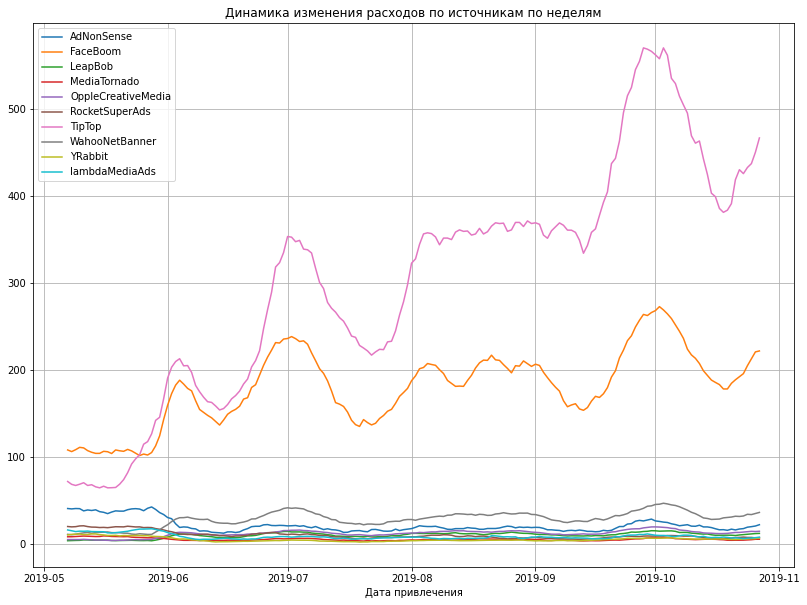

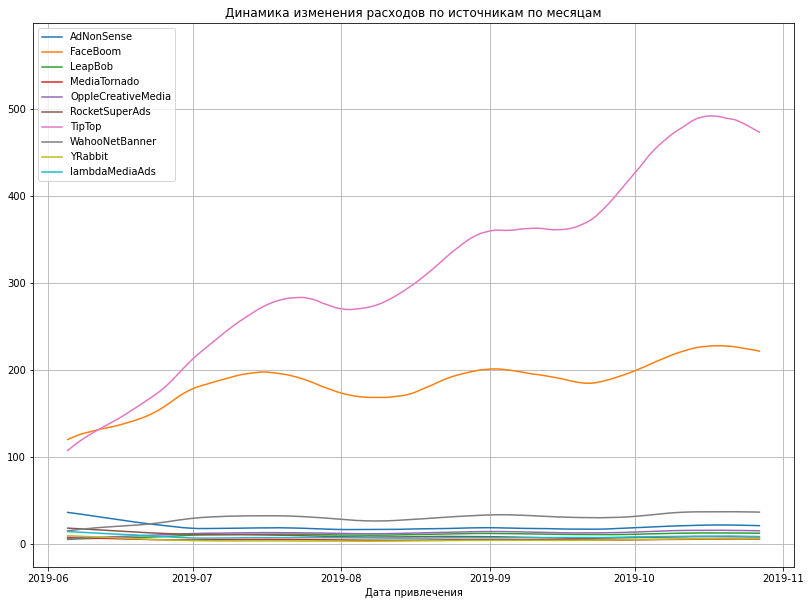

In [27]:
pivot_channel = (
    costs
    .reset_index()
    .pivot_table(index='dt', columns='channel', values='costs', aggfunc='sum')
) # построили сводную таблцу по датам и каналам 


ax1 = plt.subplot(1, 2, 1)

window = 7
# используем скользящую функцию filter_data() и строим график динамики по неделям
filter_data(pivot_channel, window).plot(grid=True, ax=ax1, figsize=(30, 10))
plt.legend()
plt.xlabel('Дата привлечения')
plt.title('Динамика изменения расходов по источникам по неделям')
plt.show()


ax2 = plt.subplot(1, 2, 2, sharey=ax1)

window = 30
# используем скользящую функцию filter_data() и строим график динамики по месяцам
filter_data(pivot_channel, window).plot(grid=True, ax=ax2, figsize=(30, 10))
plt.legend()
plt.xlabel('Дата привлечения')
plt.title('Динамика изменения расходов по источникам по месяцам')
plt.show()

**Вывод**

Общие расходы на рекламу составляют 105497.3 (долларов).

Основная часть расходов идет на два источника: TipTop и FaceBoom. На них тратится почти 83% от всех денег.

Причем на TipTop со временем тратися все больше и больше, в то время как в остальных источниках расходы довольно стабильны.

#### Узнаем, сколько в среднем стоило привлечение одного пользователя (CAC) из каждого источника. 

In [28]:
CAC_channel = (profiles
 .groupby('channel')
 .agg({'acquisition_cost': 'mean'})
 .sort_values(by='acquisition_cost', ascending=False)
 .rename(columns={'acquisition_cost': 'CAC'})
)
CAC_channel

,CAC
channel,
TipTop,2.799003
FaceBoom,1.113286
AdNonSense,1.008054
lambdaMediaAds,0.724802
WahooNetBanner,0.602245
RocketSuperAds,0.412095
OppleCreativeMedia,0.250000
YRabbit,0.218975
MediaTornado,0.218717


**Средний САС по всем источникам**

In [52]:
print('Средний САС:', CAC_channel.query('CAC > 0').mean())

Средний САС: CAC    0.755735
dtype: float64


**Вывод**

Ничего удивительного. Самое дорогое привлечение пользователей у САС, на втором месте по дороговизне - FaceBoom. Поэтому на них и уходит больше всего средств компании. В дальнейшем анализе посмотрим, окупаются ли эти траты.

### Оценим окупаемость рекламы

Используя графики LTV, ROI и CAC, проанализируем окупаемость рекламы. Будем считать, что на календаре 1 ноября 2019 года, а в бизнес-плане заложено, что пользователи должны окупаться не позднее чем через две недели после привлечения. 

- Проанализируем окупаемость рекламы c помощью графиков LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Проверим конверсию пользователей и динамику её изменения. То же самое сделаем с удержанием пользователей. Построим и изучим графики конверсии и удержания.
- Проанализируем окупаемость рекламы с разбивкой по устройствам. Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Проанализируем окупаемость рекламы с разбивкой по странам. Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Проанализируем окупаемость рекламы с разбивкой по рекламным каналам. Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Ответим на такие вопросы:
    - Окупается ли реклама, направленная на привлечение пользователей в целом?
    - Какие устройства, страны и рекламные каналы могут оказывать негативное влияние на окупаемость рекламы?
    - Чем могут быть вызваны проблемы окупаемости?

#### Проанализируем окупаемость рекламы c помощью графиков LTV и ROI, а также графики динамики LTV, CAC и ROI.

**Поскольку цель исследования - оценка маркетинговой компании, убираем из исследования источник бесплатного трафика:**

In [59]:
profiles = profiles.query('channel != "organic"') # специально перезаписываю, 
# так как дальше органические пользователи для анализа не потребуются 

In [54]:
observation_date = datetime(2019, 11, 1).date()  # момент анализа
horizon_days = 14  # горизонт анализа 

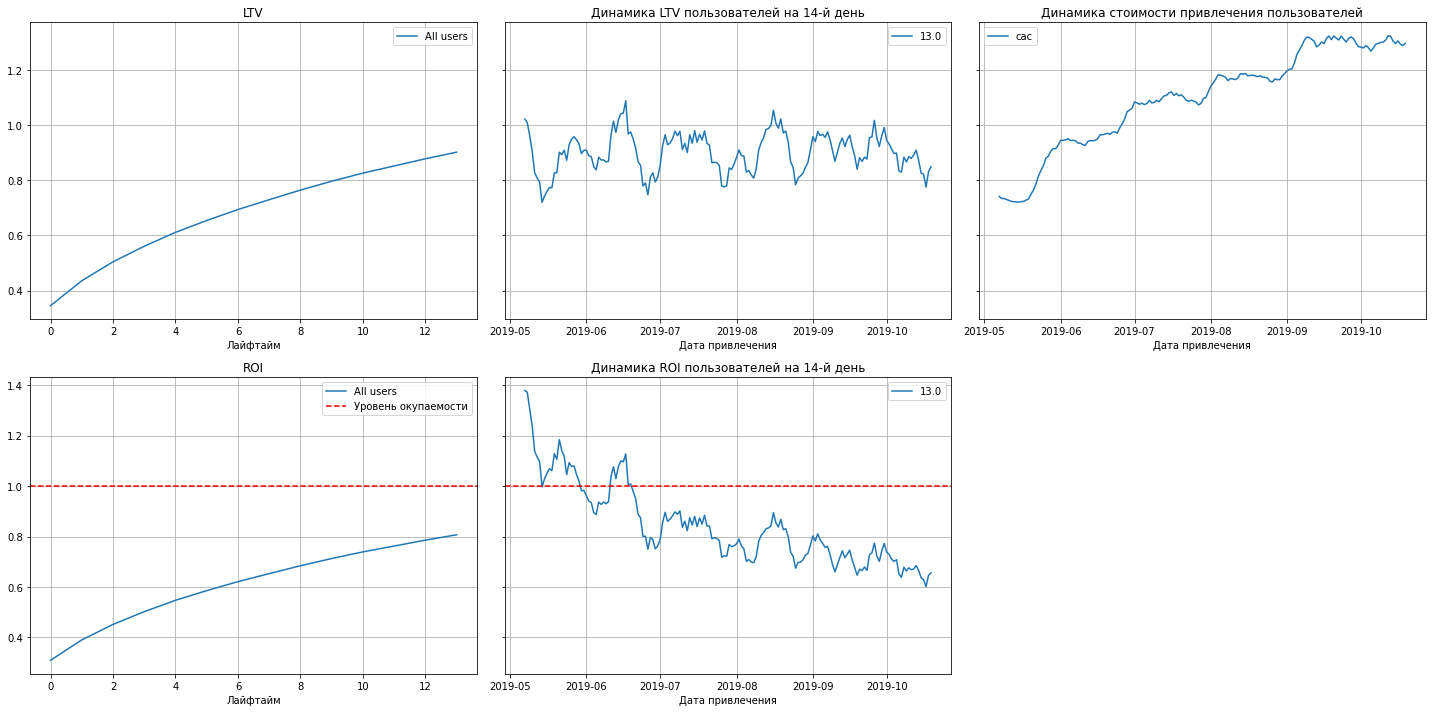

In [55]:
# считаем LTV и ROI
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days
)
# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) 

**По графикам можно сделать такие выводы:**

- Реклама не окупается. ROI в конце второй недели только подобрался к 1, то есть к тому, чтобы затраты начали окупаться. Значения окупаемости постоянно снижаются.
- САС сильно и постоянно растет. Вполне возможно, что убытки именно из-за роста стоимости привлечения новых пользователей.
- На LTV влияет сезонный фактор, но и этот показатель достаточно стабилен. Значит, дело не в ухудшении качества пользователей.

#### Проверим конверсию пользователей и динамику её изменения. 

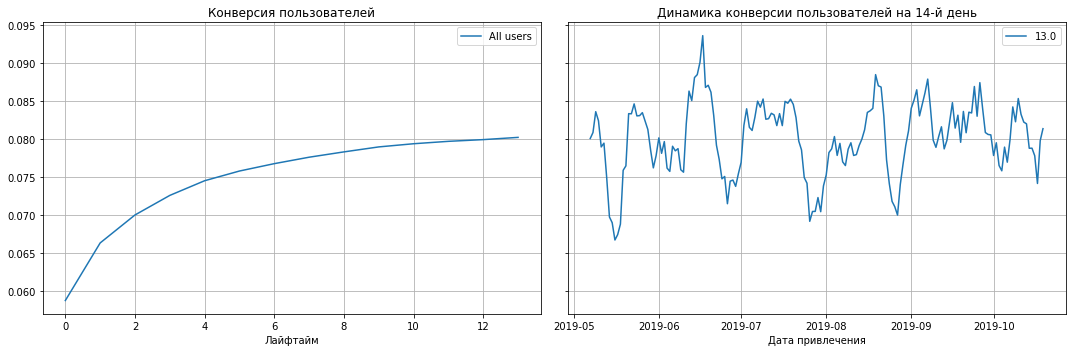

In [56]:
# смотрим конверсию 

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

**Вывод**

Конверсия постепенно растет. Скачками, но с ней всё в порядке. Посмотрим на удержание.

#### То же самое сделаем с удержанием пользователей. 

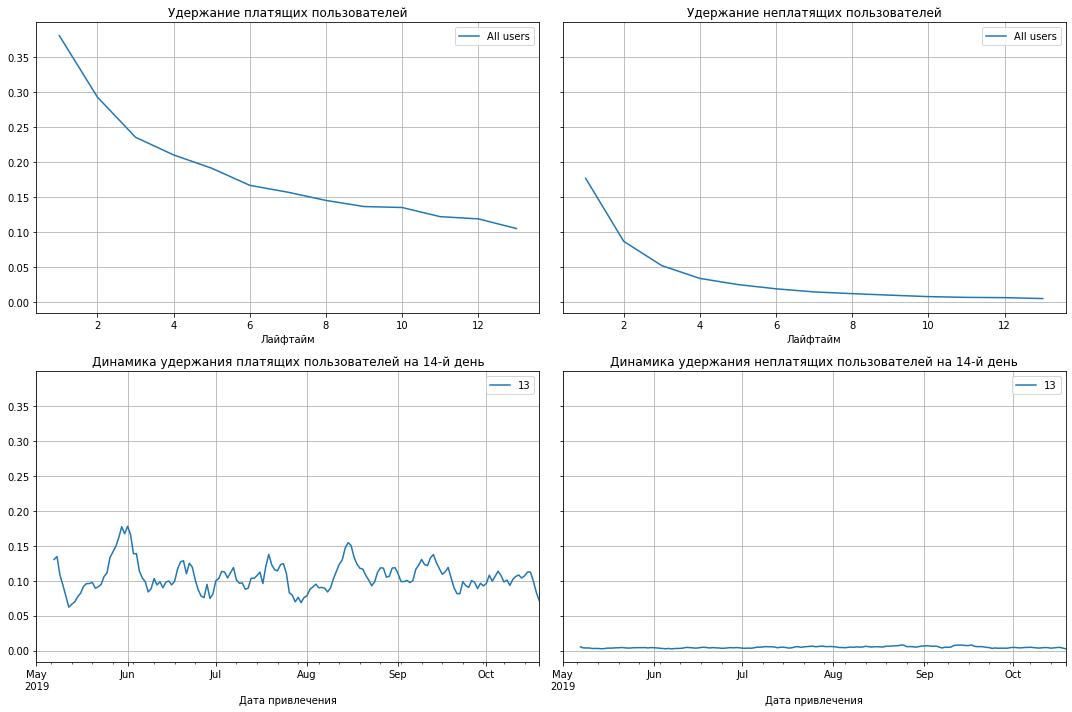

In [57]:
# смотрим удержание с разбивкой по устройствам

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days
)

plot_retention(retention_grouped, retention_history, horizon_days) 

**Вывод**

Удержание платящих довольно низкое! Уже на второй день удержание составляет около 30%, а в конце двух недель. Но динамика стабильна. Возможно, пользователям что-то не нравится в приложении, поэтому после скачивания большинство его покидает.

Удержание неплатящих пользователей практически нулевое.

#### Проанализируем окупаемость рекламы с разбивкой по устройствам. Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI.

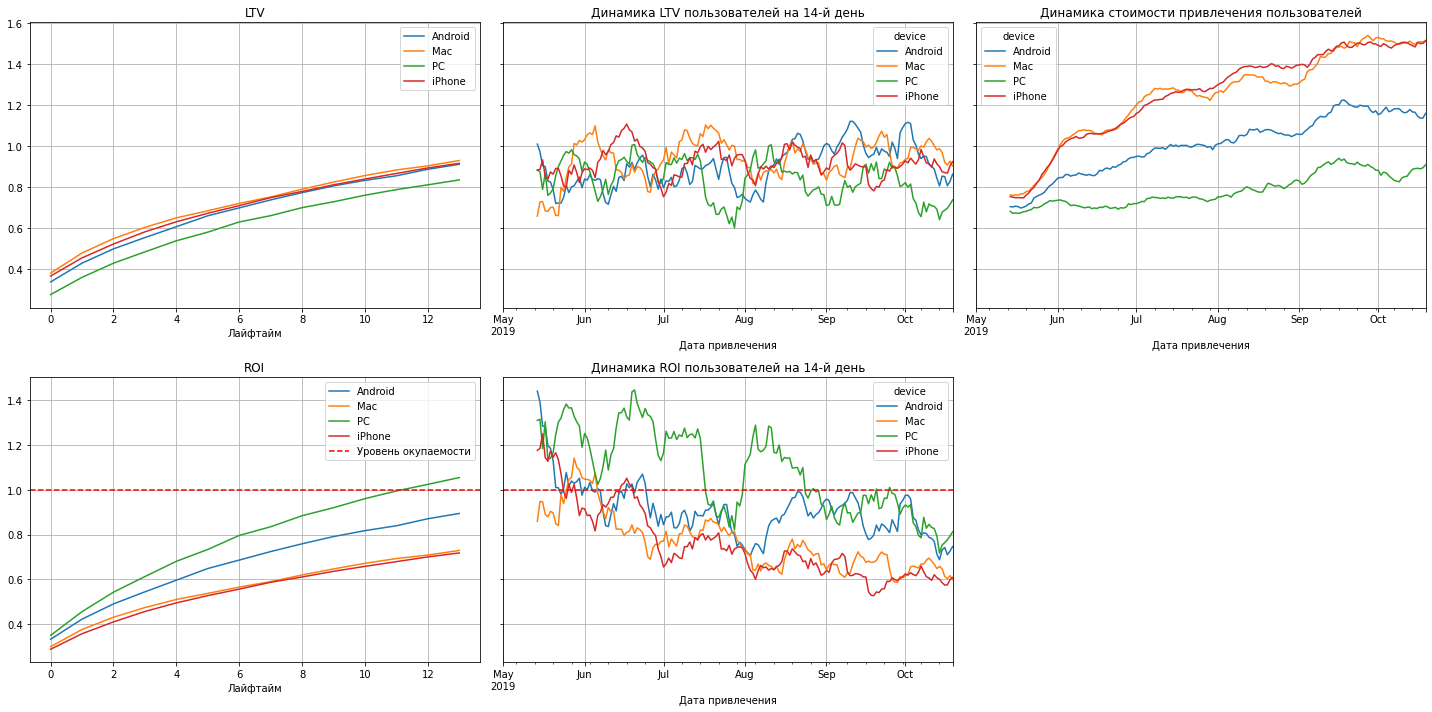

In [58]:
# смотрим окупаемость с разбивкой по устройствам

dimensions = ['device']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

**Вывод**

- LTV стабилен. Дело не в ухудшении качества пользователей.
- Стоимость привлечения увеличивается для всех устройств. Наибольший рост у IPhone и Mac. Наименьший - у PC. Не смотря на это расходы на привлечение клиентов окупаются только для устройств PC. В рассматриваемый период для всех устройств, кроме Android, ROI стабильно снижается: у Android, после падения, с августа ROI стабилизируется в диапазоне 0.65-1.0. В виду снижения ROI для PC, можно говорить о низком эффекте маркетинговой компании для данного устройства и прогнозировать его скорый переход в разряд неокупаемых.

**Посмотрим на конверсию и удержание**

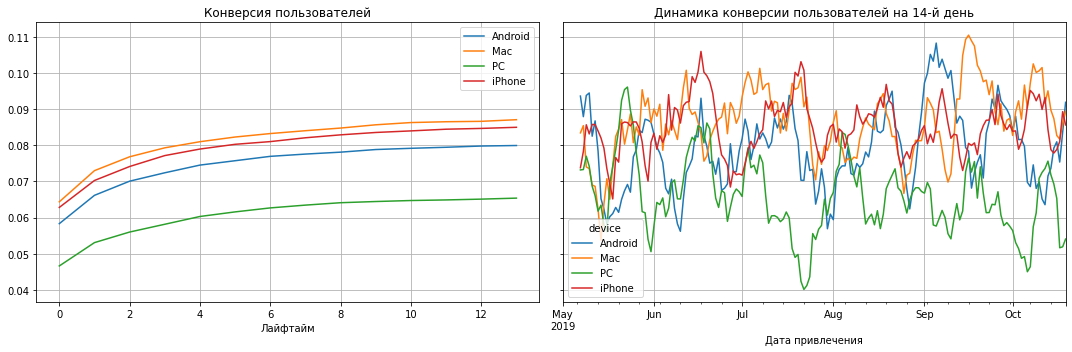

In [60]:
# смотрим конверсию с разбивкой по устройствам
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=['device']
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

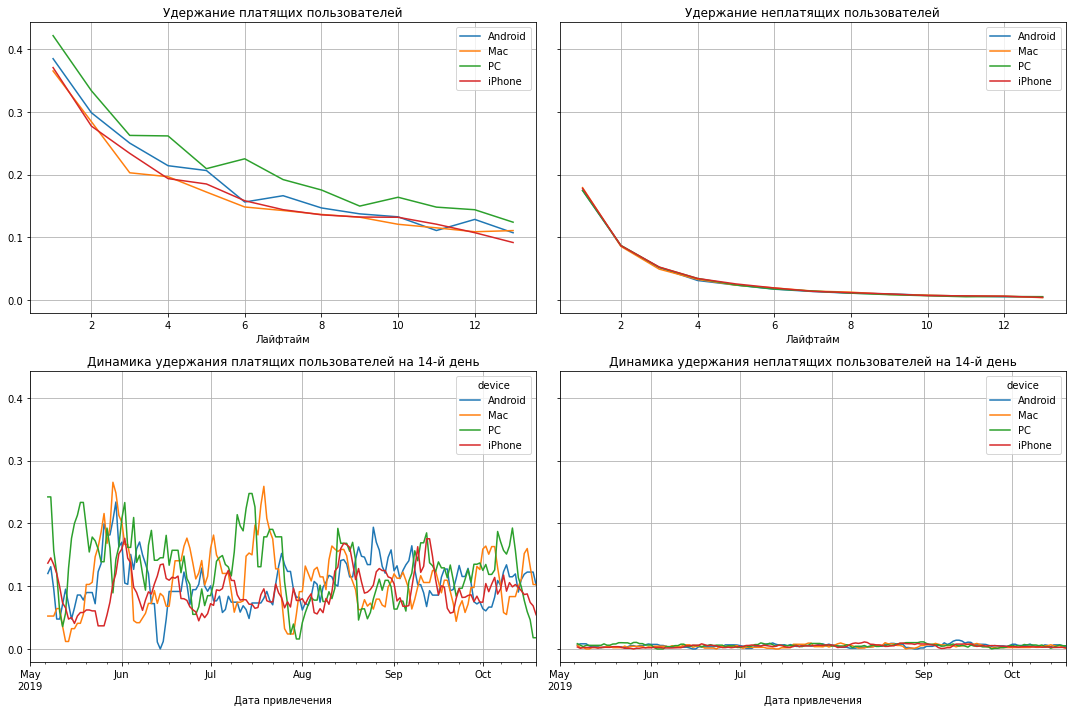

In [61]:
# смотрим удержание с разбивкой по устройствам
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=['device']
)

plot_retention(retention_grouped, retention_history, horizon_days) 

**Вывод**

В конверсии и удержании аномалий нет.

#### Проанализируем окупаемость рекламы с разбивкой по странам. Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI.

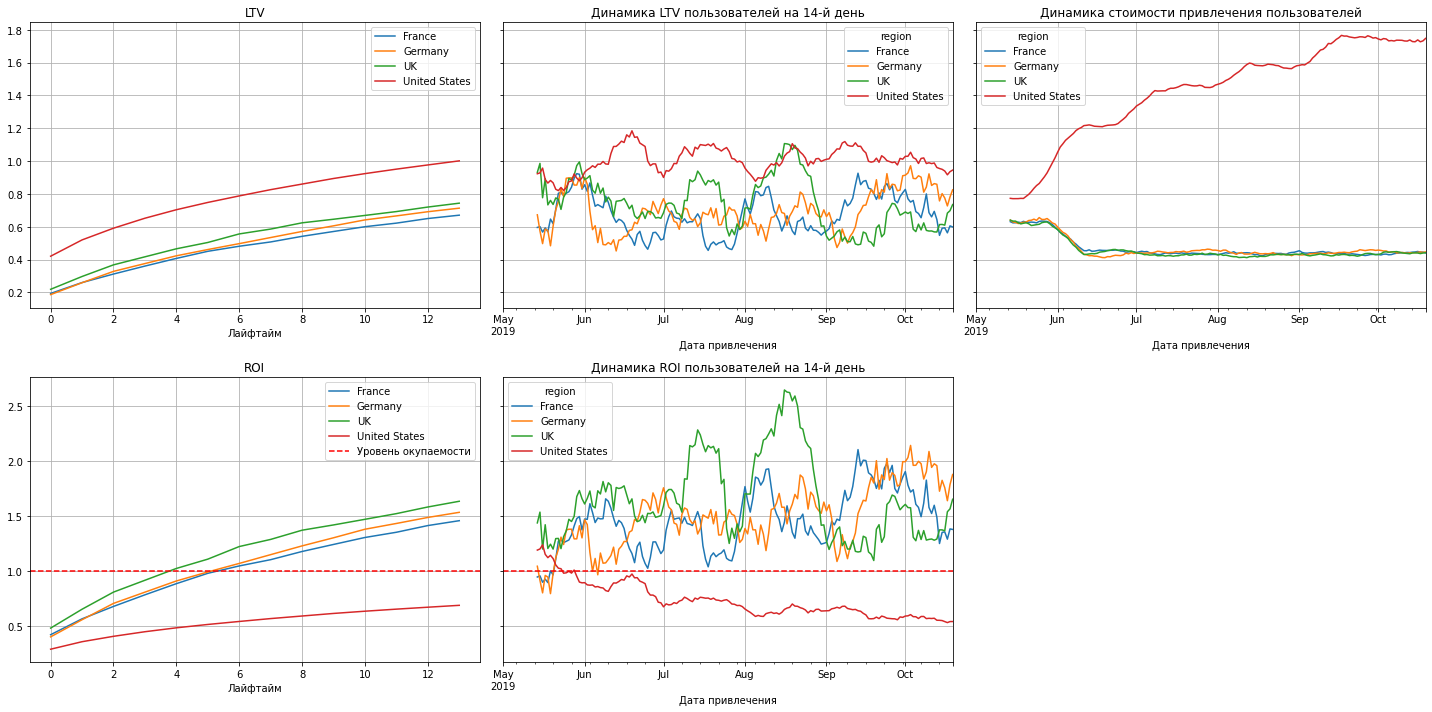

In [62]:
# смотрим окупаемость с разбивкой по странам

dimensions = ['region']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

**Вывод**

- В Соединенных Штатах показатель LTV самый высокий. В целом livetime value стабилен.
- Все старны с лихвой окупаются уже на пятный день запуска, кроме США. Они не окупились и к концу второй недели.
- В США самая дорогая стоимость привлечения пользователей, которая больше в 4 раза, чем у остальных стран, и при этом стоимость продолжает расти! Возможно, именно слишокм высокая цена сказывается на снижении ROI в США.
- У европейских стран стабильная, сезонная динамика ROI, а в США ROI уже в январе стал ниже единицы, и стабильно продолжал снижаться.

**Посмотрим на конверсию и удержание**

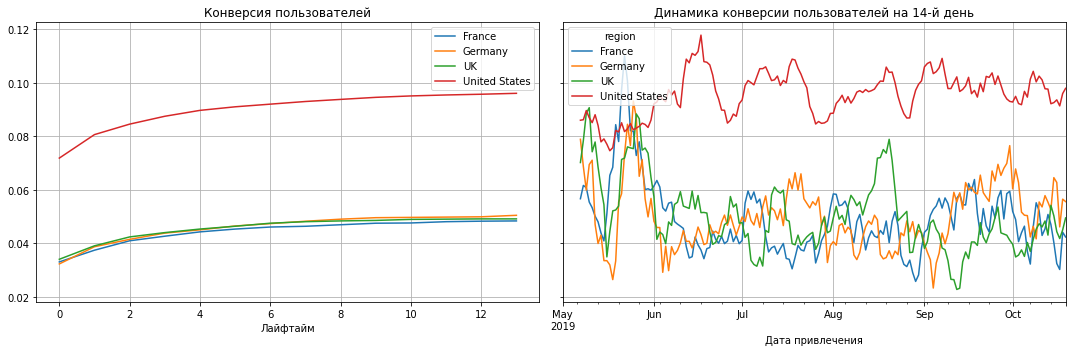

In [63]:
# смотрим конверсию с разбивкой по странам
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=['region']
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

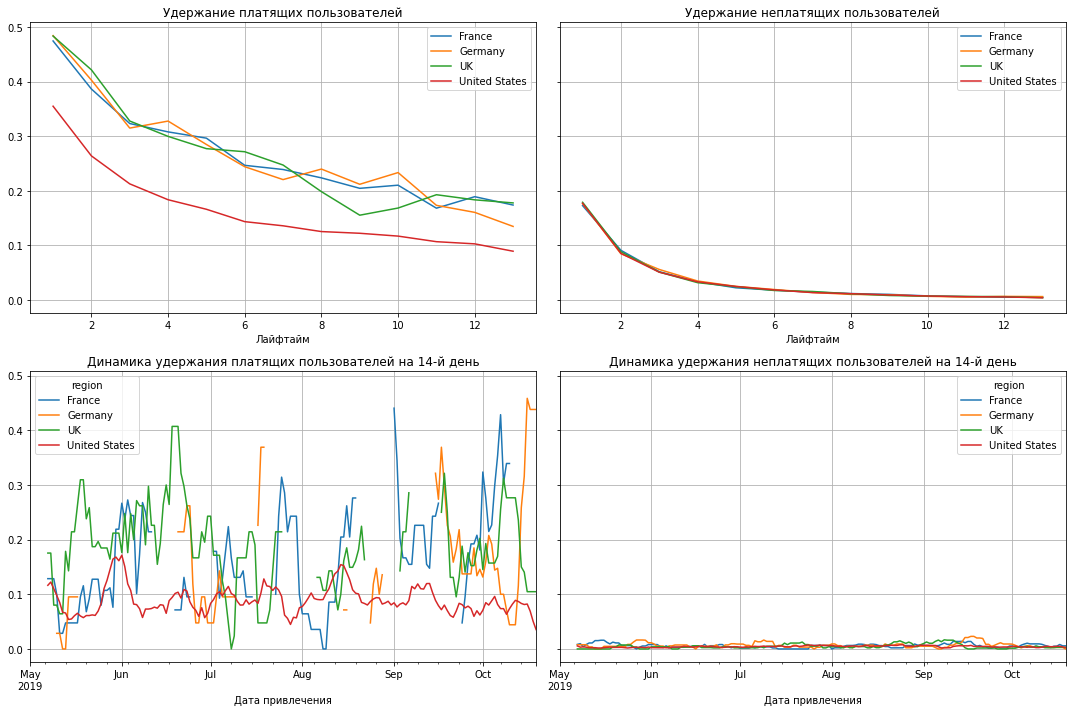

In [64]:
# смотрим удержание с разбивкой по странам
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=['region']
)

plot_retention(retention_grouped, retention_history, horizon_days) 

**Вывод**

На фоне остальных всё так же выделяются Соединенные Штаты Америки. Конверсия платящих пользователей выше всех, но при это удержание самое низкое. Что-то работает не так. Будем смотреть дальше.

#### Проанализируем окупаемость рекламы с разбивкой по рекламным каналам. Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI.

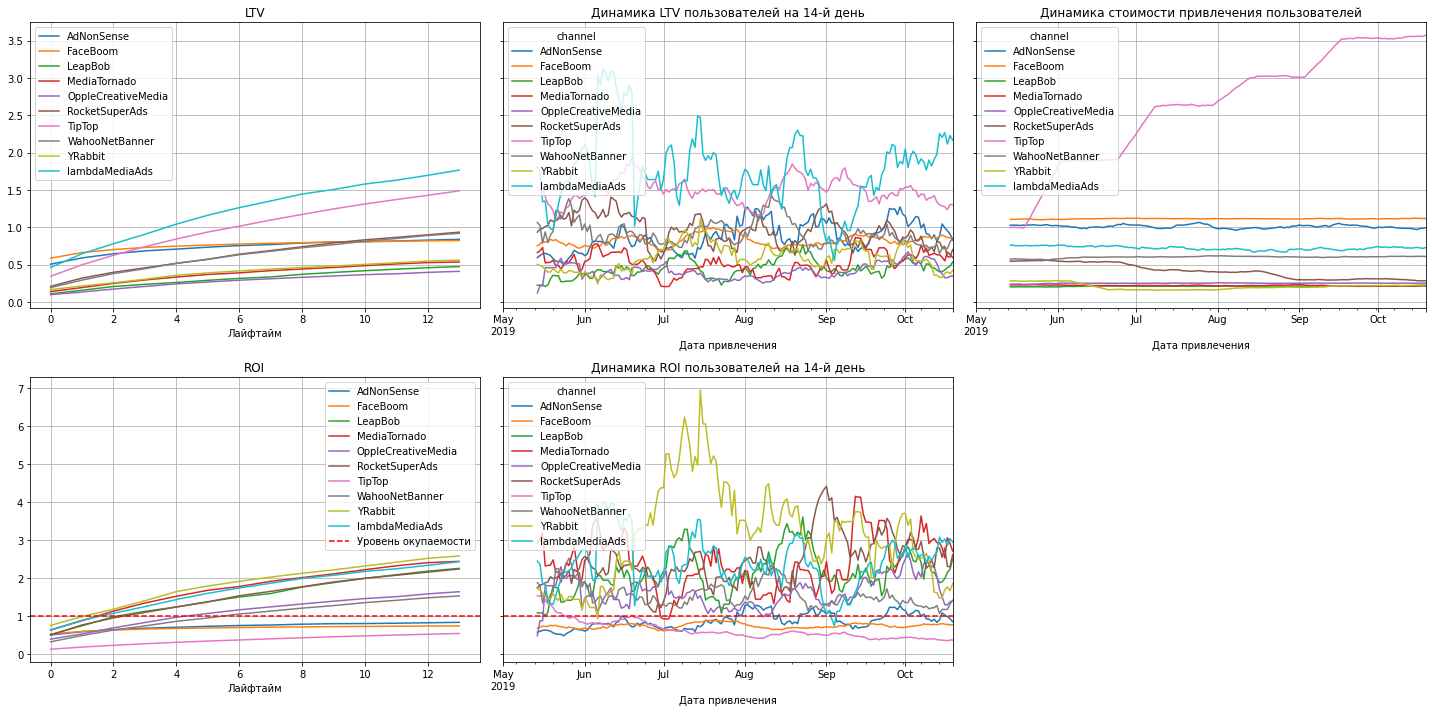

In [65]:
# смотрим окупаемость с разбивкой по рекламным каналам

dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

**Вывод**

- на графике LTV видно, что самые высокие показатели у двух источников - TipTop, куда было вложено больше всего средств компании, и lamdaMediaAds, которая обладает самыми лучшими показателями, хоть динамика и не очень стабильная.
- Реклама FaceBoom, TipTop, AdNonSence не окупаются. То есть кмпании, куда вложили больше всего финансов, не окупаются. Не удивительно, что компания терпит убытки и не может окупиться даже через 2 недели после запуска. 
- Релкама в FaceBoom стоит всегда одинаково, и при этом она не окупается. Возможно, реклама слишком дорогая (она выше всех остальных источников, кроме TipTop). Скорее всего, стоит либо договариваться на меньшую сумму, либо прекращать сотрудничество с FaceBoom, так как компания терпит убытки.
- Динамика стоимости привлечения пользователей у TipTop постоянно растет и к концу второй недели выше всех остальных более чем в 3 раза. Вот где точно убытки, так это здесь! Самый низкий ROI.


**Посмотрим на конверсию и удержание**

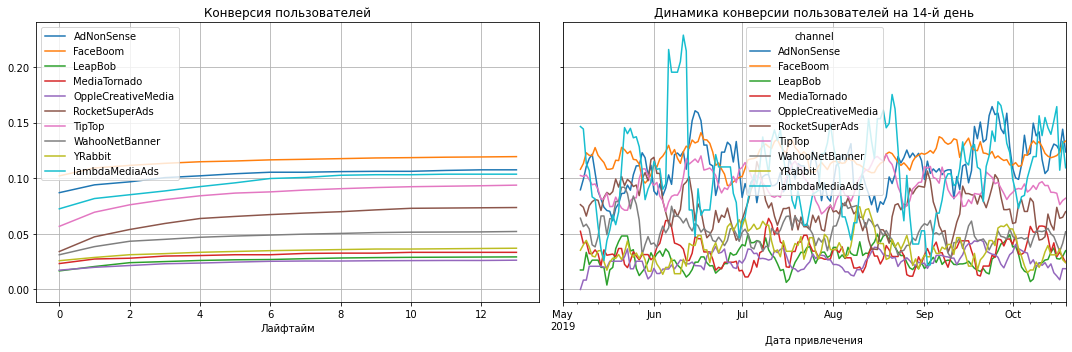

In [66]:
# смотрим конверсию с разбивкой по рекламным каналам
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=['channel']
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

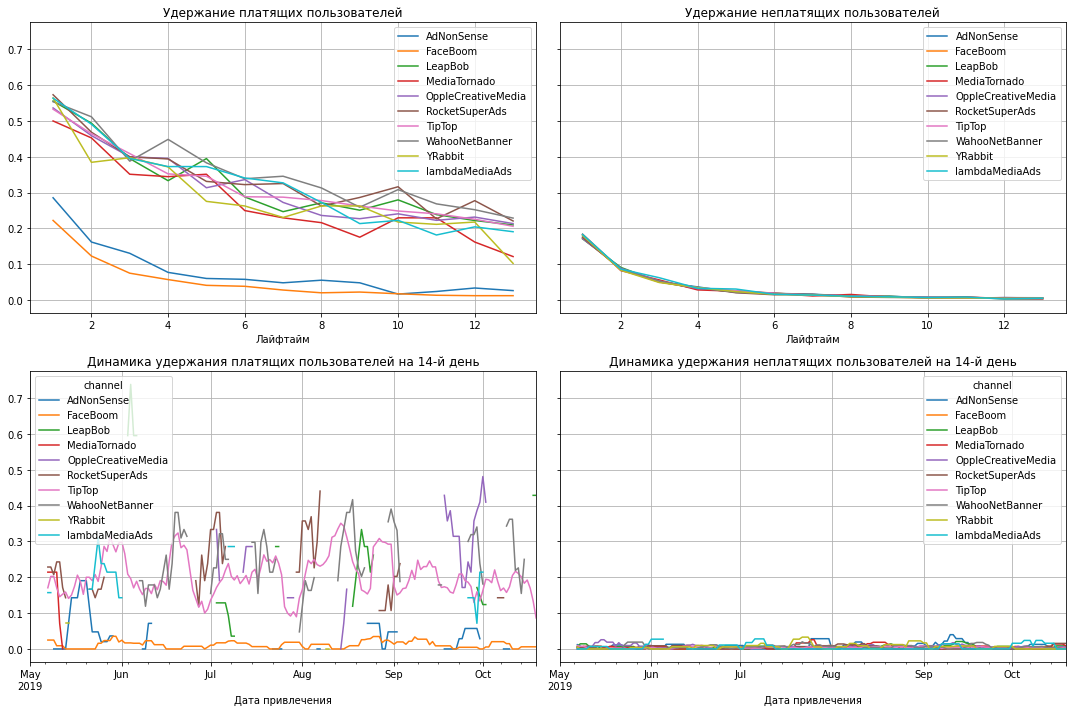

In [67]:
# смотрим удержание с разбивкой по рекламным каналам
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=['channel']
)

plot_retention(retention_grouped, retention_history, horizon_days) 

**Вывод**

У всех источников в целом довольно низкая конверсия. Из всех организаций самая высокая конверсия у FaceBoom, но при этом и самое низкое удержание вместе с AdNonSence, которая тоже в топе по неокупаемости.

#### Исследуем "провисающие" показатели

In [42]:
# дополнительно исследование по "проблемным" факторам
(profiles
 .query('payer == True and region == "United States"') # платящие пользователи именно в США
 .groupby('channel')
 .agg({'user_id': 'nunique'})
 .sort_values(by='user_id', ascending=False)
 .rename(columns={'user_id': 'number_of_new_user'})
)

,number_of_new_user
channel,
FaceBoom,3557
TipTop,1878
organic,794
RocketSuperAds,352
YRabbit,165
MediaTornado,156


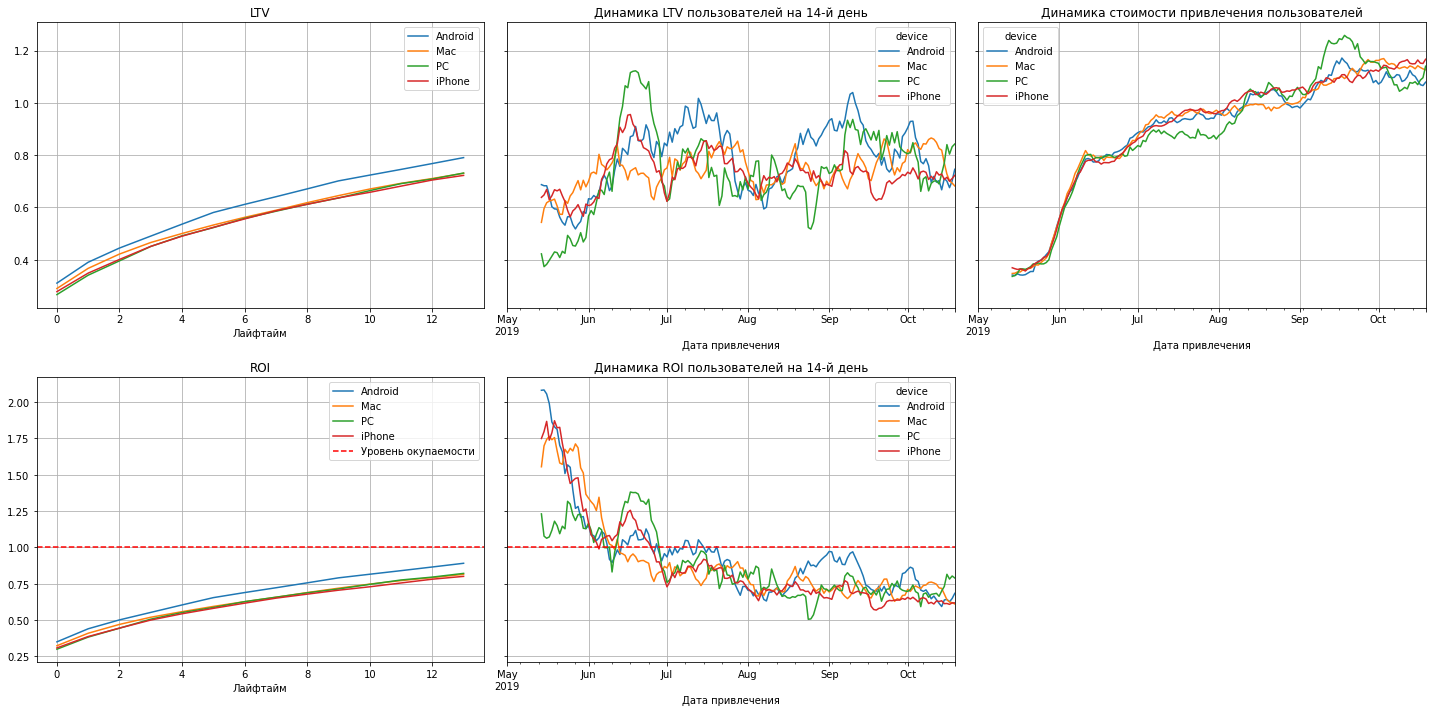

In [43]:
# смотрим окупаемость с разбивкой по устройствам в США
profiles_usa = profiles.query('region == "United States"')

dimensions = ['device']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_usa, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

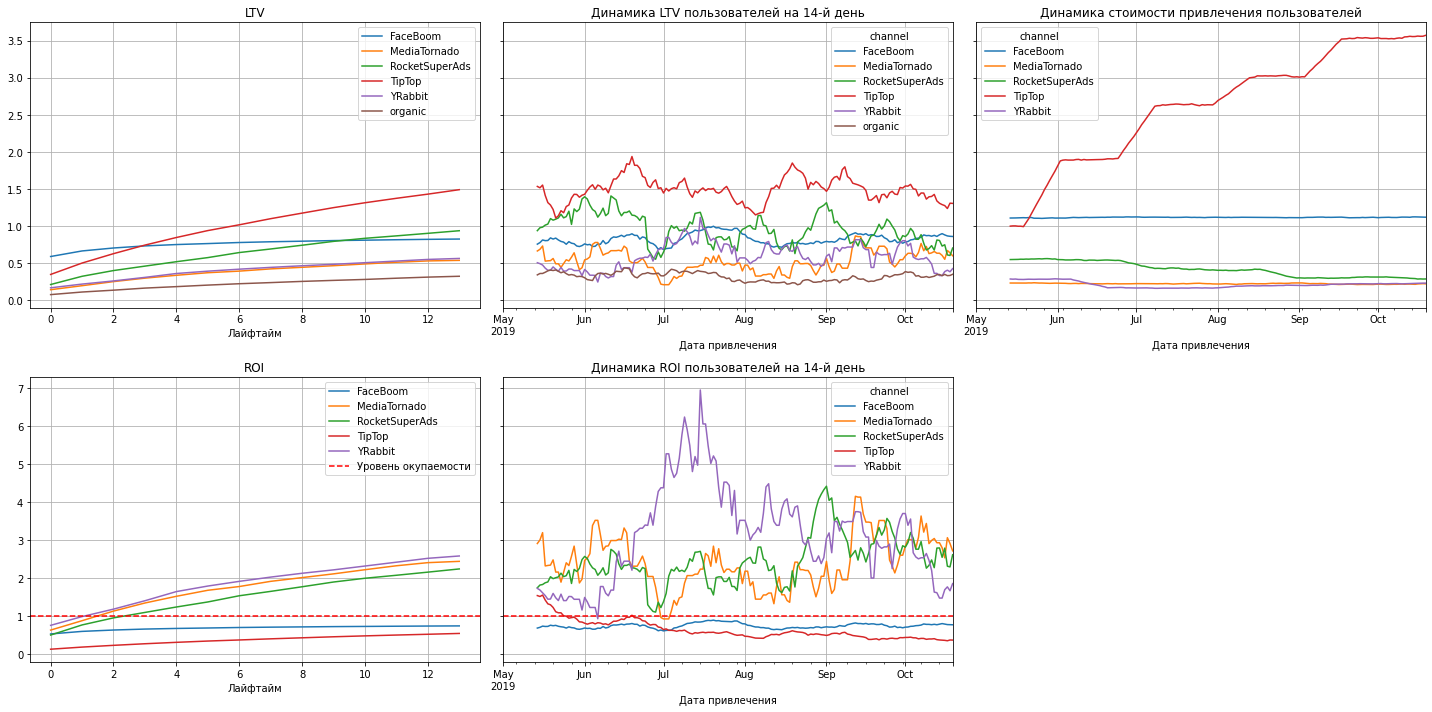

In [44]:
# смотрим окупаемость с разбивкой по рекламным каналам в США

dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_usa, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

**Вывод по США**

В США из-за того, что большинство пользователей привлекается за счет FaceBoom и TipTop - самый дорогих и неприбыльных источников, получаются сплошные убытки. На всех устройствах окупаемость в районе 80%.

**Посмотрим на Европу**

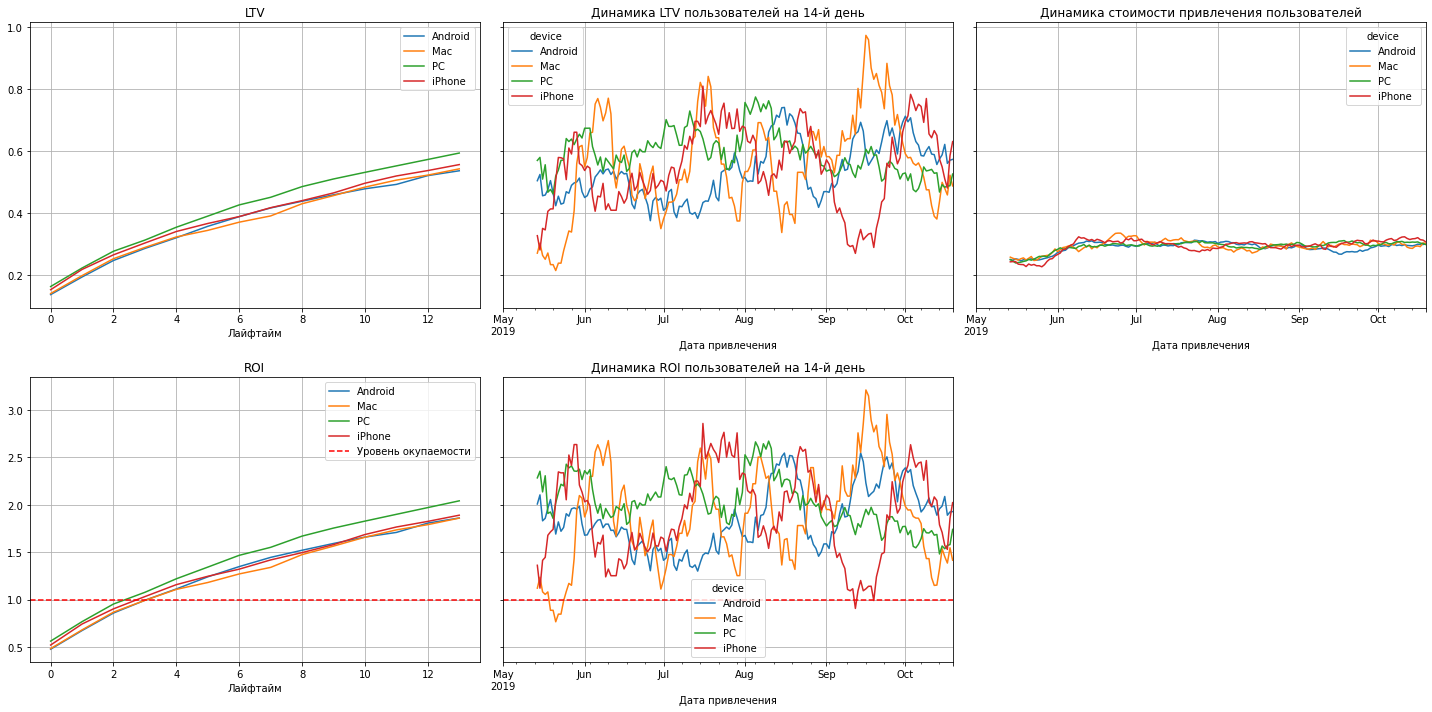

In [45]:
# смотрим окупаемость с разбивкой по устройствам в США
profiles_europe = profiles.query('region != "United States"')

dimensions = ['device']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_europe, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

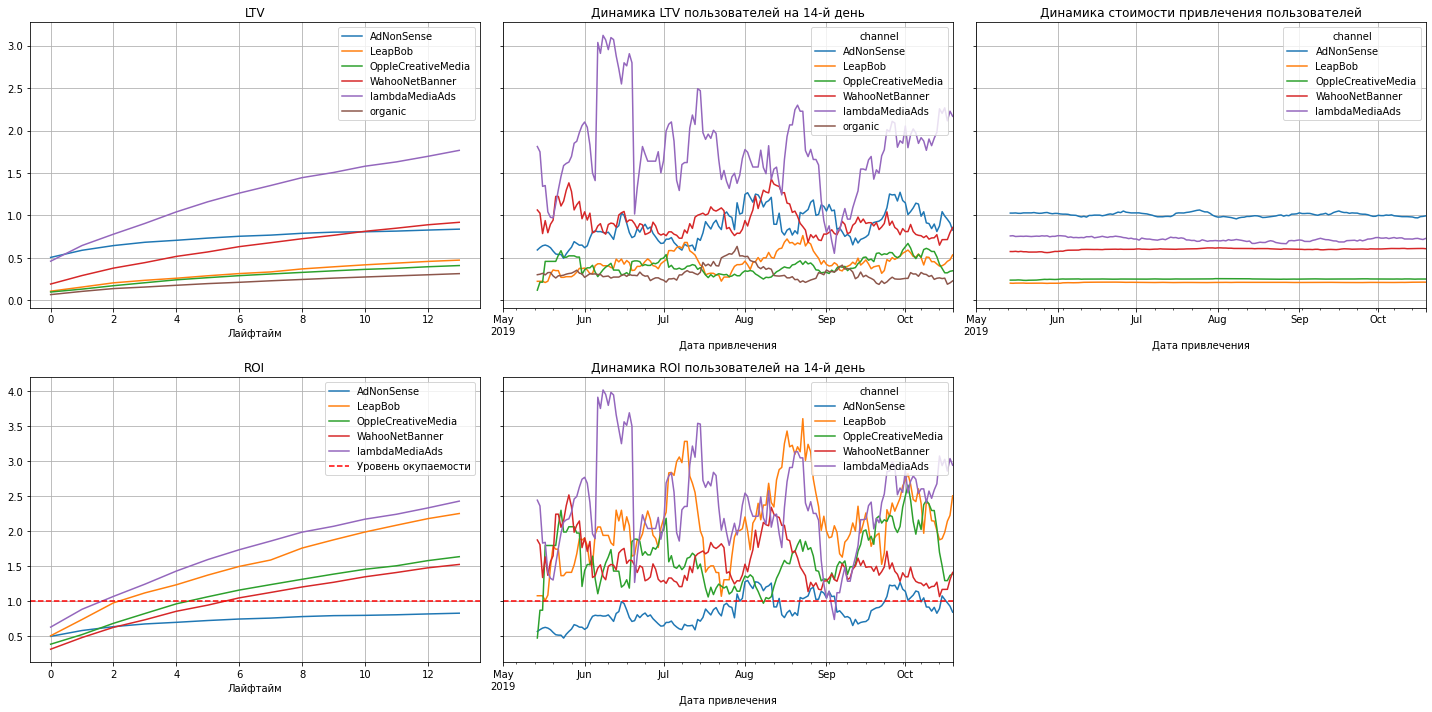

In [46]:
# смотрим окупаемость с разбивкой по рекламным каналам в США

dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_europe, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

**Вывод по Европе**

В Европе все стабильно и хорошо окупается кроме источника AdNoneSense. Он окупается лишь на 80%. В Америке его нет. Маркетологам следует обратить внимание на цену привлечения новых пользователей, так как цена стабильна и, видимо, слишком высока, раз источник не окупаетя.

**Посмотрим на устройства неокупаемых каналов**

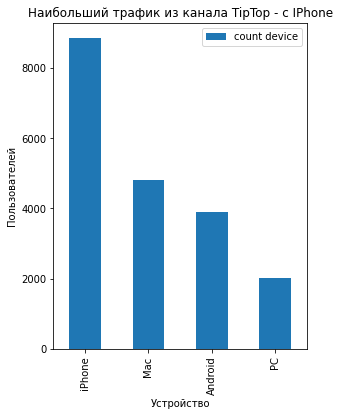

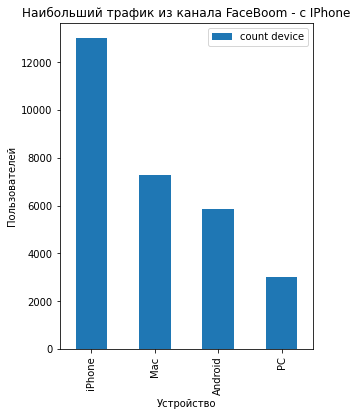

count device    70.0
dtype: float64
count device    70.0
dtype: float64


In [69]:
# Составляем бар чарты для того, чтобы посмотреть, какими устройствами пользуются клиенты 
# неокупаемых источников
device_on_TipTop = (profiles
 .query('channel == "TipTop"')
 .groupby('device')
 .agg({'user_id': 'nunique'})
 .sort_values(by='user_id', ascending=False)
 .rename(columns={'user_id': 'count device'})
)

plt.figure(figsize=(10, 6))
ax1 = plt.subplot(1, 2, 1) # здесь не понимаю, почему subplot не работает, подскажите пожалуйста
device_on_TipTop.plot(kind='bar', ax=ax1)
plt.title('Наибольший трафик из канала TipTop - с IPhone')
plt.ylabel('Пользователей')
plt.xlabel('Устройство')
plt.show()

device_on_FaceBoom = (profiles
 .query('channel == "FaceBoom"')
 .groupby('device')
 .agg({'user_id': 'nunique'})
 .sort_values(by='user_id', ascending=False)
 .rename(columns={'user_id': 'count device'})
)

plt.figure(figsize=(10, 6))
ax1 = plt.subplot(1, 2, 2)
device_on_FaceBoom.plot(kind='bar', ax=ax1, sharey=ax1)
plt.title('Наибольший трафик из канала FaceBoom - с IPhone')
plt.ylabel('Пользователей')
plt.xlabel('Устройство')
plt.show()

# посчитаем процент пользователей с техикой эпл
print(round(device_on_TipTop.head(2).sum() / device_on_TipTop.sum() * 100))
print(round(device_on_FaceBoom.head(2).sum() / device_on_FaceBoom.sum() * 100))

**Вывод**

Легко можно понять, почему айфоны и макбуки не показывают должный ROI. Так как большинство (около 70%) пользователей двух самых неокупаемых компаний используют айфон и макбук для скачивания. 

#### Итог и ответы на вопросы

**Окупается ли реклама, направленная на привлечение пользователей в целом?**
- В целом реклама не окупается. За две недели компания приблизилась к тому, чтобы выходить в ноль, но при такой динамике, которая есть сейчас, большой прибыли ждать не стоит.

**Какие устройства, страны и рекламные каналы могут оказывать негативное влияние на окупаемость рекламы?**
- Из проведенного анализа мы заметили, что привлечение пользователей с IPhone и Macbook не окупается. Это может быть связано с тем, что стоимость их привлечения выше, чем на остальных устройствах, и постоянно увеличиватеся. Что связано с тем, что 70% пользователей, привлеченных по неокупаемым источникам TipTop и FaceBoom. Показатели этих компаний тянет за собой вниз и эти два устройства.
- В США реклама не окупается. Во всех остальных странах уже в первые несколько дней компания уходит в плюс. Дело в источниках привлечения. Реклама слишком дорогая! Основные источники - TipTop и FaceBoom, стоимость привлечения у которых в 3 раза выше, чем у всех остальных. Также в США самый большой коэффицент отскока среди всех стран. Получается, что на пользователей из США тратят больше всего рекламного бюджета и при этом ничего не окупается. После дополнительного анализа стало многое понятно. В США основные источники новых пользователей - самые дорогие по привлечению компании, на которые уходит почти 83% бюджета и при этом они не окупаются. Поэтому США убыточны. Маркетологам однозначно стоит обратить на это внимание. 
- Негативное влияние оказывают такие источники, как: TipTop и FaceBoom. У них самая дорогая реклама и при этом у FaceBoom самый болшой отскок. Маркетологам стоит задуматься над тем, чтобы активнее развивать другие источники с меньшей стоимостью привлечения и большей конверсией.

**Чем могут быть вызваны проблемы окупаемости?**
- Проблемы окупаемости могут быть вызваны неправильным распределением рекламных средств. Почти все финансы направлены на неокупаемые компании. Стоит присмотреться к более стабильным и прибыльным.
- Также могут быть проблемы с пользователями продукции Apple.

### Вывод

**Причины неэффективности привлечения пользователей**

- Низкая эффективность рекламы по каналу tiptop (США)

Наибольшие траты на привлечение пользователей приходятся на канал tiptop, стоимость клиента значительно выше этого параметра у других каналов. Наибольшее количество пользователей приходят из США, где один из основных источников трафика – канал tiptop. Соответственно, при высокой стоимости привлечения пользователей, окупаемость в 50% ведет к значительным убыткам.

- Низкая эффективность рекламы по каналу faceboom (США)

Затраты на рекламу по данному каналу стабильно увеличиваются, при этом маркетинговая компания по каналу faceboom окупается лишь на 70%. Столь низкий результат связан с высокой стоимостью привлечения пользователей и крайне низким удержанием.

- Низкая окупаемость рекламных компаний для устройств mac и iphone
- Низкая окупаемость рекламной компании по каналу AdNoneSense (Европа).

Маркетинговая компания по каналу AdNoneSense окупается на 80%, при том, что для него стоимость привлечения клиентов среди европейских каналов максимальная.

**Рекомендации для отдела маркетинга**

- Оптимизировать рекламу по каналу tiptop. В случае невозможности увеличения значения окупаемости - уменьшить затраты на данный канал до значений на май 2019 года и вернуться к рекламной концепции, действовавшей на тот момент: тогда ROI был выше границы окупаемости.
- Оптимизировать рекламу по каналу faceboom. В случае невозможности увеличения значения окупаемости - прекратить рекламу по данному каналу.
- Часть высвободившихся средств направить на рекламу по каналу adnonsense. Поскольку и без дополнительных вливаний в рекламу по данному каналу ROI в июле поднимается до границы окупаемости, то можно сделать вывод, что у пользователей adnonsense со временем появляется интерес к приложению. Дополнительная реклама может этот интерес подогреть.
- Часть высвободившихся средств направить на рекламу по каналам rocketsuperads, mediatornado и yrabbit, чтобы компенсировать потери на рынке США. К тому же дополнительные вливания могут остановить снижение ROI канала yrabbit.
- Оптимизировать рекламную компанию по каналам lambdamediaads (Европа) и leapbob (Европа). LTV и ROI данных каналов имеют большую амплитуду колебаний, а значит есть потанциал для роста: можно за счет уменьшения амплитуды подтянуть средние значения LTV и ROI к верхней границе диапазона колебаний.
- По той же причине оптимизировать рекламную компанию в Соединенном Королевстве.
- По той же причине оптимизировать рекламную компанию для устройств mac.